In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
from pathlib import Path

sys.path.append(str(Path().cwd().parent))

In [7]:
import pandas as pd
from dataset import Dataset
from model import TimeSeriesPredictor, TimeSeriesDetector
from sklearn.linear_model import Ridge

In [8]:
import plotting

In [9]:
from typing import Tuple

## Разбор (запускать не надо)

#### Возьмем часовой временной ряд

In [10]:
dataset = Dataset('../data/dataset')

In [11]:
ts = dataset['hour_2263.csv']

<Axes: xlabel='2019-05-19 04:00:00'>

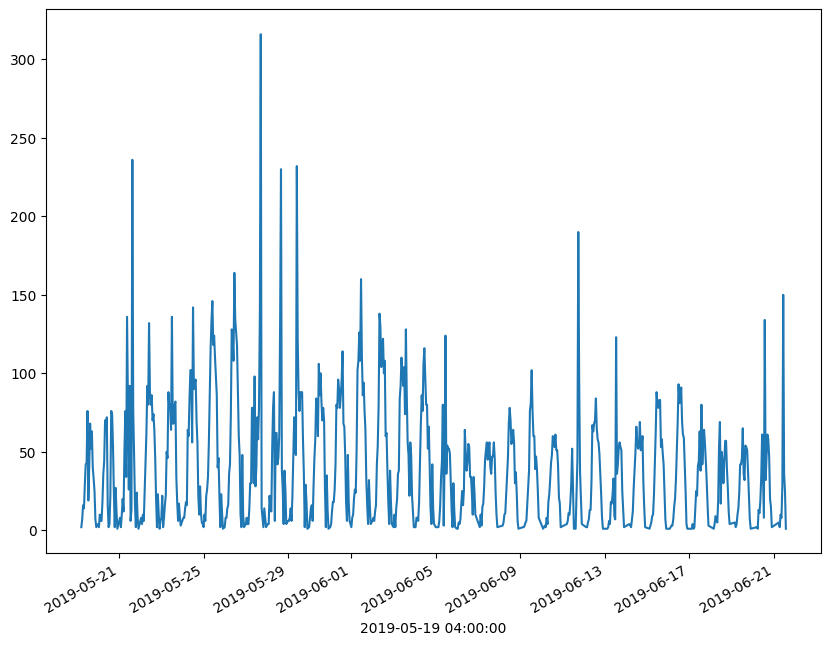

In [12]:
ts.plot(figsize=(10, 8))

#### Разделим на трейн и тест

In [13]:
ts_train, ts_test = ts[:-100], ts[-100:]

#### Создадим инстанс детектора с Ridge в качестве базы

In [14]:
detector = TimeSeriesDetector(
    granularity='PT1H',
    num_lags=24,
    model=Ridge,
    alpha=7,
    sigma=2.3
)

#### Обучим модель на трейне

In [15]:
detector.fit(ts_train)

#### Используя обученную модель, соберем статистику с трейна

In [16]:
detector.fit_statistics(ts_train)

/Users/technogleb/ts_march_2024/model.py:237: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  unite_ts = pd.concat([ts, ts_batch])


In [17]:
detector.std

25.631191715807347

#### Сделаем in-sample прогноз на ts_test

In [18]:
preds = detector.predict_batch(ts_train, ts_test)

#### Используя найденную статистику (стандартное отклонение от остатков), получим доверительные интервалы

In [19]:
lower, upper = detector.get_prediction_intervals(preds)

In [20]:
lower

2019-05-19 04:00:00
2019-06-16 06:00:00   -55.228754
2019-06-16 07:00:00   -46.399480
2019-06-16 08:00:00   -38.137490
2019-06-16 09:00:00   -34.585596
2019-06-16 10:00:00   -24.313869
                         ...    
2019-06-21 10:00:00   -47.671428
2019-06-21 11:00:00   -41.368601
2019-06-21 12:00:00    12.669042
2019-06-21 13:00:00   -30.708042
2019-06-21 14:00:00   -19.407205
Length: 100, dtype: float64

In [21]:
upper

2019-05-19 04:00:00
2019-06-16 06:00:00     62.674728
2019-06-16 07:00:00     71.504002
2019-06-16 08:00:00     79.765992
2019-06-16 09:00:00     83.317886
2019-06-16 10:00:00     93.589612
                          ...    
2019-06-21 10:00:00     70.232054
2019-06-21 11:00:00     76.534881
2019-06-21 12:00:00    130.572524
2019-06-21 13:00:00     87.195440
2019-06-21 14:00:00     98.496277
Length: 100, dtype: float64

#### Получим аномалии

In [22]:
anoms = detector.detect(ts_test, preds)

In [23]:
anoms

2019-05-19 04:00:00
2019-06-20 14:00:00    134.0
2019-06-21 11:00:00    150.0
Name: 2.0, dtype: float64

In [24]:
plotting.plot_detection(ts_test, upper, lower, preds)

Loading BokehJS ...

## Практика

In [176]:
class TimeSeriesDetector(TimeSeriesPredictor):
    def __init__(self, sigma=2.7, percentile=0.99, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.sigma = sigma

    def fit_statistics(self, ts: pd.Series):
        """
        Используя метод predict_batch получает in-sample предсказания на ряде ts.
        Далее получает остатки, вычитая этот прогноз из факта. На остатках считает
        стандартное отклонение и записывает его в аттрибут std
        """
        self.std = std

    def get_prediction_intervals(self, y_pred: pd.Series, season=False) -> Tuple[pd.Series]:
        """
        Используя найденный std остатков, заданную self.sigma и предсказанные значения y_pred,
        возвращает для них доверительные интервалы
        """
        return lower, upper

    def detect(self, ts_true, ts_pred, season=False) -> pd.Series:
        """
        Используя метод get_predictions_intervals, получает те значения ряда ts_true,
        которые выходят за границы доверительных интервалов
        """
        return 

    def fit_seasonal_statistics(self, ts_train, n_splits=3, period=24):
        pass

## Практика. Часть1. Базовая.

### Задание 1. Метод fit_statistics.

Добавить в класс `TimeSeriesPredictor` метод `fit_statistics`, который при помощи обученной модели получает остатки
предсказаний на трейне и возвращает стандартное отклонение остатков.
* принимает на вход ряд ts
* используя метод `self.predict_batch` получает in-sample прогноз для ts
* получает остатки, вычитая прогноз из факта

если мы точно уверены, что остатки распределены нормально
* на остатках считает стандартное отклонение и записывает его в аттрибут `self.std`

если мы не уверены, что остатки распределены нормально

* расчитать эмперическое значение перцентиля на остатках и записать его в аттрибут `self.std`

### Задание 2. Метод get_predictions_intervals.

Добавить в класс TimeSeriesPredictor метод get_prediction_intervals, который принимает предсказанный батч ts_pred,  и, используя std на трейне возвращает для каждой точки ее lower и upper доверительные интервалы.

* принимает на вход предсказанный батч y_pred
* возвращает для него верхний и нижный интервал по формуле `upper, lower = y_pred +/- sigma * std` в случае нормальных остатков
* возвращает для него верхний и нижный интервал по формуле `upper, lower = y_pred +/- std` в случае остатков, расчитанных при помощи bootstrapping-a

### Задание 3. Метод detect.

Добавить в класс TimeSeriesPredictor метод detect, который принимает на вход ts_true и ts_pred и возвращает          значения ряда, выходящие за границы доверительных интервалов. 

## Практика. Часть 2. Продвинутая.

* Самое важное допущение данного метода заключается в том, что остатки нашего метода хоть как-то похожи на нормальные.

* Одно из очевидных нарушений "нормальности" остатков можно наблюдать в тех рядах, где шумовая компонента имеет разную дисперсию в зависимости от того, в каком моменте периода сезонности она находится. Так, например, у нашего ряда шум днем, "в пиках" ряда, явно выше того, что наблюдается рано утром или ночью, что объясняется естественным отличием в бизнес правилах.

* Одним из способов справиться с проблемой выше может быть метод расчета сезонных интервалов, когда вместо расчета стандартного отклонения остатков на всей истории ряда, мы считаем стандартное отклонение, соответствующее определенному периоду на сезонном интервале

### Задание 1. Метод fit_seasonal_statistics.

Добавить метод `fit_seasonal_statistics`, который бы возвращал стандартное отклонение остатков предсказания для       `n_splits` равных участков внутри периода сезонности. Например для часовых рядов возвращал сигмы для `n_splits=3` участков: с        0 до 8-ми утра, с 8-ми утра до 16 вечера, с 16 до полуночи. 
* `def fit_seasonal_statistics(self, ts_train, n_splits=3, period=24):`  
       # получаю предсказания ts_train  
       # разбиваю остатки на datetime интервалы длинной period/n_splits  
       # считаю стандартное отклонение для каждого участка  
       # записываю стандартное отклонение в аттрибут self.season_std = {  
                                                                        datetime_range_1: std_1,  
                                                                        datetime_range_2: std_2,  
                                                                        datetime_range_3: std_3,  
                                                                        }  



### Задание 2. Модифицировать get_predictions_intervals.

В метод `get_prediction_intervals` добавить параметр `season=True/False`, который, будучи включенным, определяет к 
какому из интервалов в `self.season_std` относится каждая точка из `ts_pred`, и, использую соответствующий `std`, 
возвращает для нее доверительные интервалы.